In [399]:
# Import CVX and numpy libraries
import cvxpy as cvx
import numpy as np
import random
import time
import math
import networkx as nx
import matplotlib.pyplot as plt

# Problem 1: SOCP, SDP and Unconstrained Optimization


Code to randomly generate the programming problems. The generate function randomly spawns anchor points and sensor locations as well as an adjacency matrix, which enumerates which sensors are connected to which anchors/sensors.

In [400]:
#Function to generate a random problem, in 
# n dimensions with npoints number of points
def generate(n,npoints):
    # Set the limits of the domain
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    #Set up some problem characteristics
    if(n > 1): # 2-D and 3-D cases
        minConstr = 3 # Minimum number of constraints per point
        maxConstr = 4 # Approximately maximum number of constraints
        minAnchConstr = 2 # Minimum number of anchor constraints
    else:
        minConstr = 2 # Minimum number of constraints per point
        maxConstr = 3 # Approximately maximum number of constraints
        minAnchConstr = 1 # Minimum number of anchor constraints
    
    # Build the adjacency matrix
    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                # If the point with which to set the constraint is different
                if(pointList[l] != i):
                    # Make sure that the node to connect does 
                    # not have too many constraints
                    countConstr = 0
                    for k in range(npoints+off):
                        if(adjacency[k,pointList[l]+off] > 0):
                            countConstr = countConstr + 1
                    if(countConstr < maxConstr):
                        # Add the new constraint
                        adjacency[pointList[l]+off,i+off] = \
                            np.linalg.norm(p[pointList[l]] - p[i])
                        adjacency[i+off,pointList[l]+off] = \
                            adjacency[pointList[l]+off,i+off]
                        count = count - 1
                l = l + 1
    return [a, p, adjacency]

The following code forces the sensors to be located within the convex hull of the anchors.

In [401]:
#The exact same function above with the exception that
#now the points are forced inside the convex hull
def generate_inside_hull(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)
    
    if(n == 1):
        a = np.array([-6., 6.])
    elif(n == 2):
        a = np.array([[-6., 15.], [-6., -15.], [8., 0.]])
    elif(n == 3):
        a = np.array([[-6., 15.,-10.], [-6., -15.,-10.], \
                      [8., 0., -10.], [0., 0., 10.]])
    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                    countConstr = 0
                    for k in range(npoints+off):
                        if(adjacency[k,pointList[l]+off] > 0):
                            countConstr = countConstr + 1
                    if(countConstr < maxConstr):
                        adjacency[pointList[l]+off,i+off] = \
                            np.linalg.norm(p[pointList[l]] - p[i])
                        adjacency[i+off,pointList[l]+off] = \
                            adjacency[pointList[l]+off,i+off]
                        count = count - 1
                l = l + 1
    return [a, p, adjacency]

## SOCP

Solve the SOCP problem with n dimensions and npoints sensors

In [431]:
def SOCP(n, npoints, convex, niters, printOut = False, timing = True):
    #Generate the anchors, sensor locations and the corresponding adjacency matrix
    totalRMSE = 0
    start = time.time()
    for k in range(niters):
        #To catch any exceptions
        while True:
            try:
                #Force problem in or outside the convex hull
                if convex:
                    (a, p, adjacency) = generate(n, npoints)
                else:
                    (a, p, adjacency) = generate_inside_hull(n, npoints)

                # Compute the Euclidian distances to the anchor points
                adjSize = len(p) + len(a)
                asize = len(a)
                d = []

                #Retrieve the distances from adjacency matrix
                for i in range(adjSize):
                    for j in range(adjSize):
                        if(j > i and adjacency[i][j] > 0 and i < asize):
                            d.append((adjacency[i][j], j - asize, i, True))
                        elif(j > i and adjacency[i][j] > 0):
                            d.append((adjacency[i][j], i - asize, j - asize, False))

                # Construct the CVX variables to minimize
                x = [cvx.Variable(n) for i in range(len(p))]

                states = []
                constr = []

                #Construct the obj fcn as well as the constraints
                #These correspond to SOCP constraints
                cost = cvx.norm(0)
                for (distance, i, j, truth) in d:
                    if(truth):
                        constr.append(cvx.norm(x[i] - a[j], 2) ** 2 <= distance ** 2)
                    else:
                        constr.append(cvx.norm(x[i] - x[j], 2) ** 2 <= distance ** 2)

                states.append(cvx.Problem(cvx.Minimize(cost), constr))

                # Add the states and solve the problem    
                prob = sum(states)
                prob.solve()
                
                if printOut:
                    print "Anchor points: ", a
                    
                #Compute RMSE
                RMSE = 0
                #Depending on the dimension, cater the output
                if(n == 1): #Solves it more or less
                    for i, elem in enumerate(x):
                        soln1 = elem.value
                        point1 = p[i]
                        if printOut:
                            print("Sensor " + str(i) + " is at " + \
                                  str(soln1) + " and the actual value is " + \
                                  str(point1))
                        RMSE += np.linalg.norm(soln1 - point1) ** 2
                elif(n == 2): #Can't solve this)
                    for i, elem in enumerate(x):
                        soln1 = elem.value.A.flatten()
                        soln1 = ['%.4f' % elem for elem in soln1]
                        soln1 = [float(elem) for elem in soln1]
                        point1 = ['%.4f' % elem for elem in p[i]]
                        point1 = [float(elem) for elem in point1]
                        if printOut:
                            print("Sensor " + str(i) + " is at " + str(soln1) + \
                                  " and the actual value is " + \
                                  str(point1))
                        RMSE += np.linalg.norm(np.asarray(soln1) - \
                                               np.asarray(point1)) ** 2
                else:
                    for i, elem in enumerate(x):
                        soln1 = elem.value.A.flatten()
                        soln1 = ['%.4f' % elem for elem in soln1]
                        soln1 = [float(elem) for elem in soln1]
                        point1 = ['%.4f' % elem for elem in p[i]]
                        point1 = [float(elem) for elem in point1]
                        if printOut:
                            print("Sensor " + str(i) + " is at " + str(soln1) + \
                                  " and the actual value is " + str(point1))
                        RMSE += np.linalg.norm(np.asarray(soln1) - \
                                               np.asarray(point1)) ** 2
            except:
                continue
            break
    
        #Add to the running total for the RMSE
        totalRMSE += RMSE
        
        end = time.time()
        
        #If the dimension = 2 then plot the graph
        if(n == 2 and printOut):
            G=nx.Graph()

            for i in range(n+1):
                G.add_node(i,pos=a[i])

            for i in range(npoints):
                G.add_node(n+1+i,pos=p[i])

            pos=nx.get_node_attributes(G,'pos')

            nx.draw_networkx_nodes(G,pos,
                                   nodelist=[i for i in range(n+1)],
                                   node_color='r',
                                   node_size=100,
                                   alpha=0.8,
                                   with_labels=True)
            nx.draw_networkx_nodes(G,pos,
                                   nodelist=[i for i in range(n+1,npoints+n+1)],
                                   node_color='b',
                                   node_size=100,
                                   alpha=0.8,
                                   with_labels=True)
            for i in range(npoints+n+1):
                for j in range(n+1,npoints+n+1):
                    if(adjacency[j,i] > 0.):
                        G.add_edge(i,j)

            nx.draw_networkx_edges(G, pos)
            nx.draw_networkx_labels(G, pos,font_color='w', \
                                    font_size=8,font_weight='bold')
            plt.draw()  # pyplot draw()
            
    #Compute the timing and the RMSE
    if timing:
        print "Total time elapsed(sec): ", end - start
    print "Average Root Mean Squared Error: ", math.sqrt(totalRMSE/niters)

Anchor points:  [[-1.24061837 -0.55795391]
 [ 2.56835104 -0.13244273]
 [-4.35839429 -4.82609378]]
Sensor 0 is at [1.471, -0.5913] and the actual value is [4.1492, -1.5227]
Sensor 1 is at [0.5339, -1.3045] and the actual value is [1.5191, -2.4637]
Sensor 2 is at [0.4944, -0.5121] and the actual value is [0.3957, 0.3343]
Sensor 3 is at [2.4744, -0.1632] and the actual value is [2.7428, -0.2082]
Sensor 4 is at [2.0732, -0.3688] and the actual value is [4.4904, -0.4515]
Sensor 5 is at [0.4996, -1.1834] and the actual value is [4.2803, -3.8445]
Sensor 6 is at [-1.5066, -1.4559] and the actual value is [-3.011, 0.7971]
Sensor 7 is at [-0.068, -1.8885] and the actual value is [0.8515, -3.0421]
Sensor 8 is at [-0.5539, -1.9454] and the actual value is [1.8406, -4.4702]
Sensor 9 is at [-3.2366, -4.0638] and the actual value is [-3.0714, -4.3568]
Total time elapsed(sec):  0.359204053879
Average Root Mean Squared Error:  7.7534863655


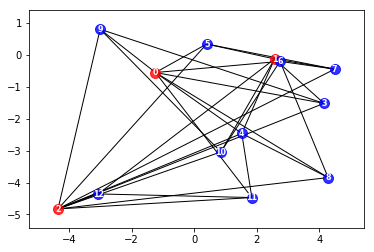

In [432]:
#Solve 2-D with 10 sensors outside the convex hull
SOCP(2, 10, True, 1, True)

Anchor points:  [[ -6.  15.]
 [ -6. -15.]
 [  8.   0.]]
Sensor 0 is at [3.4504, 4.7177] and the actual value is [3.4505, 4.7178]
Sensor 1 is at [-3.2187, 3.9301] and the actual value is [-1.137, 4.3267]
Sensor 2 is at [-3.9177, 3.5643] and the actual value is [-3.9177, 3.5643]
Sensor 3 is at [4.3217, 1.841] and the actual value is [4.3217, 1.841]
Sensor 4 is at [2.8746, 1.5629] and the actual value is [2.8746, 1.5629]
Sensor 5 is at [0.6261, -1.593] and the actual value is [1.9492, -2.2667]
Sensor 6 is at [0.4349, -3.2459] and the actual value is [2.806, -4.6094]
Sensor 7 is at [0.0618, 0.2883] and the actual value is [0.0618, 0.2883]
Sensor 8 is at [-2.1504, -4.4019] and the actual value is [-2.1504, -4.4019]
Sensor 9 is at [4.6062, 3.6363] and the actual value is [1.0624, -1.2807]
Total time elapsed(sec):  0.356856822968
Average Root Mean Squared Error:  7.13525659455


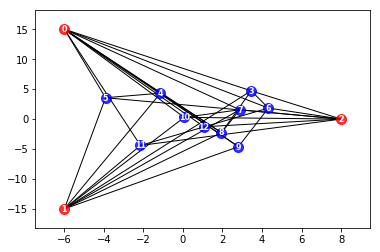

In [407]:
#Solve 2-D with 10 sensors inside the convex hull
SOCP(2, 10, False, 1, True)

In [408]:
#Solve 1-D with 10 sensors randomly generated
SOCP(1, 10, True, 100)

Total time elapsed(sec):  8.29544711113
Average Root Mean Squared Error:  9.42692399813


In [409]:
#Solve 1-D with 10 sensors inside the convex hull
SOCP(1, 10, False, 100)

Total time elapsed(sec):  9.96485209465
Average Root Mean Squared Error:  5.81985405852


In [410]:
#Solve 2-D with 10 sensors outside the convex hull
SOCP(2, 10, True, 100)

Total time elapsed(sec):  11.263933897
Average Root Mean Squared Error:  12.2941148022


In [411]:
#Solve 2-D with 10 sensors inside the convex hull
SOCP(2, 10, False, 100)

Total time elapsed(sec):  24.3332779408
Average Root Mean Squared Error:  7.04751513325


In [412]:
#Solve 3-D with 10 sensors outside the convex hull
SOCP(3, 10, True, 100)

Total time elapsed(sec):  9.46475696564
Average Root Mean Squared Error:  15.7684826823


In [413]:
#Solve 3-D with 10 sensors inside the convex hull
SOCP(3, 10, False, 100)

Total time elapsed(sec):  10.029624939
Average Root Mean Squared Error:  15.0895796464


## SDP

We now perform the same operation done above with the SOCP problem as with the SDP problem. Note that all that changes is the constraint types.

In [433]:
def SDP(n, npoints, convex, niter, printOut = False):
    #Keep time and a running total of the RMSE to average later on
    start = time.time()
    totalRMSE = 0
    for iteration in range(niter):
        if convex:
            (a, p, adjacency) = generate(n, npoints)
        else:
            (a, p, adjacency) = generate_inside_hull(n, npoints)

        # Compute the Euclidian distances to the anchor points
        adjSize = len(p) + len(a)
        asize = len(a)
        d = []

        #Retrieve the distances
        for i in range(adjSize):
            for j in range(adjSize):
                if(j > i and adjacency[i][j] > 0 and i < asize):
                    d.append((adjacency[i][j], j - asize, i, True))
                elif(j > i and adjacency[i][j] > 0):
                    d.append((adjacency[i][j], i - asize, j - asize, False))

        #Dimension of our adjancency matrix and our z matrix
        T = n + npoints

        z = cvx.Semidef(T)
        
        #The following code constructs all the constraints of the SDP 
        #problem.
        eyeConstraint = []
        anchorConstraints = []
        pointConstraints = []

        for i in range(n):
            temp = np.zeros((T,T))
            temp[i][i] = 1
            eyeConstraint.append(temp)

        temp = np.zeros((T,T))
        for i in range(n):
            for j in range(n):
                temp[i][j] = 1
        eyeConstraint.append(temp)

        for (distance, i, j, truth) in d:
            if truth:
                temp = np.zeros(npoints)
                temp[i] = -1.
                anchorConstraints.append((np.outer(np.append(a[j], temp), \
                                          np.append(a[j], temp)), distance))
            else:
                tempi = np.zeros(npoints)
                tempj = np.zeros(npoints)
                tempi[i] = 1.
                tempj[j] = 1.
                temp = tempi - tempj
                corner = np.zeros(n)
                temp = np.append(corner, temp)
                pointConstraints.append((np.outer(temp,temp), distance))

        #Another empty states list
        states = []
        
        #Construct the cost and constraints
        cost = cvx.norm(0)
        constr = []

        for i, mat in enumerate(eyeConstraint):
            if i < len(eyeConstraint) - 1:
                constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == 1)
            else:
                constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == n)

        for mat in anchorConstraints:
            constr.append(cvx.sum_entries(cvx.mul_elemwise(mat[0], z)) ==  \
                                                              mat[1] ** 2)

        for mat in pointConstraints:
            constr.append(cvx.sum_entries(cvx.mul_elemwise(mat[0], z)) ==  \
                                                              mat[1] ** 2)
        #Force the matrix to be SDP
        constr.append(z >> 0)

        #Add the constraints and cost function
        states.append(cvx.Problem(cvx.Minimize(cost), constr))

        #Solve the SDP relaxation problem
        prob = sum(states)
        prob.solve();    
        
        #Compute this trials RMSE
        RMSE = 0
        for i in range(npoints):
            soln1 = z.value.A[0:n, i + n]
            point1 = p[i]
            if printOut:
                print("Sensor " + str(i) + " is located at " + str(soln1) + " and the actual value is " + str(point1))
            RMSE += np.linalg.norm(np.asarray(soln1) - np.asarray(point1)) ** 2
    
        #Add the trial's RMSE to the running total
        totalRMSE += RMSE
    #Compute the total RMSE
    end = time.time()
    print "Total Time Elapsed: ", end - start
    print "Average RMSE: ", math.sqrt(totalRMSE / niter)

In [441]:
SDP(2, 10, True, 1, True)

Sensor 0 is located at [ 0.6237891   1.82014375] and the actual value is [ 0.62054758  1.82257295]
Sensor 1 is located at [ 2.12336648 -2.9972174 ] and the actual value is [ 1.8966841  -3.13944462]
Sensor 2 is located at [ 4.21792369  4.66594832] and the actual value is [ 4.2671952   4.64651543]
Sensor 3 is located at [ 2.89410492  4.58177234] and the actual value is [ 2.94306109  4.56241905]
Sensor 4 is located at [ 2.3207963   0.89353663] and the actual value is [ 2.50379035  0.81448951]
Sensor 5 is located at [-0.2330296  -3.55660157] and the actual value is [-0.26426638 -3.54482724]
Sensor 6 is located at [ 1.03445186  1.77782522] and the actual value is [ 0.98041212  1.79973514]
Sensor 7 is located at [ 2.21477017 -2.81781003] and the actual value is [ 2.25120086 -2.83189328]
Sensor 8 is located at [ 0.02506119 -3.02008301] and the actual value is [ 0.01925351 -3.01901888]
Sensor 9 is located at [-0.32293434  3.64746991] and the actual value is [-0.33584087  3.65387271]
Total Time

In [442]:
#Solve 1-D case with SDP with 10 sensors outside the convex hull
SDP(1, 10, True, 100, False)

Total Time Elapsed:  5.99583005905
Average RMSE:  1.08563903171


In [443]:
#Solve 1-D case with SDP with 10 sensors inside the convex hull
SDP(1, 10, False, 100, False)

Total Time Elapsed:  10.6839389801
Average RMSE:  0.49179208328


In [444]:
#Solve 2-D case with SDP with 10 sensors outside the convex hull
SDP(2, 10, True, 100, False)

Total Time Elapsed:  13.4767358303
Average RMSE:  2.16532826806


In [445]:
#Solve 2-D case with SDP with 10 sensors inside the convex hull
SDP(2, 10, False, 100, False)

Total Time Elapsed:  29.088793993
Average RMSE:  1.09069415472


In [446]:
#Solve 3-D case with SDP with 10 sensors outside the convex hull
SDP(3, 10, True , 100, False)

Total Time Elapsed:  21.108424902
Average RMSE:  8.25953386162


In [447]:
#Solve 3-D case with SDP with 10 sensors inside the convex hull
SDP(3, 10, False, 100, False)

Total Time Elapsed:  27.4014310837
Average RMSE:  7.26055582663


## Unconstrained Optimization

In [422]:
# We compute the SNL objective function
def SNL(a, x, d):
    sum_obj = 0
    
    for (distance, i, j, truth) in d:
        if truth:
            sum_obj += ((np.linalg.norm(a[j] - x[i]) ** 2) - \
                        distance ** 2) ** 2
        else:
            sum_obj += (((np.linalg.norm(x[i] - x[j]) ** 2) - \
                        distance ** 2) ** 2)/2
    
    return sum_obj

# Here, we perform the gradient of the objective function
def dSNL(a, x, d, npoints, n):
    sum_x = np.zeros((npoints, n))
    
    for (distance, i, j, truth) in d:
        if truth:
            sum_x[i] += 4 * (np.linalg.norm(a[j] - x[i]) ** 2 - \
                             distance ** 2) * (-a[j] + x[i])
        else:
            sum_x[i] += 4 * (np.linalg.norm(x[i] - x[j]) ** 2 - \
                             distance ** 2) * (x[i] - x[j])

    return sum_x

# Updated steepest descent where we perform it twice for the two
# different sensors
def steepest_descent_2(op, dop, a, xin, d, niter, npoints, n):
    x = np.copy(xin)
    
    for i in range(0, niter):
            direction = dop(a, x, d, npoints, n)
            
            alpha = 1.
            
            for j in range(npoints):
                while(op(a, x  - alpha * direction, d) > op(a, x, d) \
                      - 0.5 * alpha * np.dot(direction[j], direction[j])):
                        if alpha < 1e-9:
                            break
                        alpha *= 0.9

            x -= alpha * direction
    
    return x

In [423]:
import copy
def unconstrained(n, npoints, convex, niter, printOut):
    #Like we did for the previous functions, we compute a running
    #total for RMSE and start and end times
    start = time.time()
    totalRMSE = 0
    
    #Compute multiple iterations
    for iteration in range(niter):
        
        #Differences between generation schemes
        if convex:
            (a, p, adjacency) = generate(n, npoints)
        else:
            (a, p, adjacency) = generate_inside_hull(n, npoints)

        # Compute the Euclidian distances to the anchor points
        adjSize = len(p) + len(a)
        asize = len(a)
        d = []

        #Retrieve the distances
        for i in range(adjSize):
            for j in range(adjSize):
                if(j > i and adjacency[i][j] > 0 and i < asize):
                    d.append((adjacency[i][j], j - asize, i, True))
                elif(j > i and adjacency[i][j] > 0):
                    d.append((adjacency[i][j], i - asize, j - asize, False))
        
        #Randomly generate a starting point
        x = [np.random.rand(n) for i in range(npoints)]
        
        #This is so that we can have both directions 
        #of the edge in the gradient
        d2 = copy.copy(d)
        for k in range(len(d)):
            (distance, i, j, truth) = d[k]
            if not truth:
                d2.append((distance, j, i, truth))
        
        #Compute the steepest descent and RMSE and add to the
        #running total
        soln = steepest_descent_2(SNL, dSNL, a, x, d2, 40, npoints, n)
        RMSE = 0
        for i in range(npoints):
            if printOut:
                print("Sensor " + str(i) + " is located at " + str(soln[i]) + \
                      " and the actual value is " + str(p[i]))
            RMSE += np.linalg.norm(np.asarray(soln[i]) - np.asarray(p[i])) ** 2
        totalRMSE += RMSE
    
    #Time the algorithm
    end = time.time()
    print "Total time elapsed: ", end - start
    print "Average RMSE: ", math.sqrt(totalRMSE / niter)

In [424]:
unconstrained(2, 10, True, 1, True)

Sensor 0 is located at [ 1.57835787  4.48574312] and the actual value is [ 1.57463426  4.51521257]
Sensor 1 is located at [-4.06512537  2.13692847] and the actual value is [-4.08220565  2.15065139]
Sensor 2 is located at [-2.72793189 -1.91778923] and the actual value is [-2.78045488 -1.89616651]
Sensor 3 is located at [ 2.47030385 -3.23352364] and the actual value is [ 2.48115864 -3.23807993]
Sensor 4 is located at [-0.75079182 -3.46403899] and the actual value is [-0.62229379 -3.30679818]
Sensor 5 is located at [-2.7915589  -4.33753945] and the actual value is [-2.77358879 -4.33471284]
Sensor 6 is located at [ 0.50210365 -2.89958744] and the actual value is [ 0.50004549 -2.89972821]
Sensor 7 is located at [-1.87179258 -0.98400392] and the actual value is [-1.89172994 -0.92564308]
Sensor 8 is located at [-1.19243939 -1.9041064 ] and the actual value is [-0.63881511 -1.90345735]
Sensor 9 is located at [ 1.78760252  3.77857429] and the actual value is [ 1.17497876  4.27085436]
Total time

In [425]:
#Solve 1-D case with steepest descent with 10 sensors outside the convex hull
SDP(1, 10, True, 100)

Total Time Elapsed:  6.54781889915
Average RMSE:  0.370136491554


In [426]:
#Solve 1-D case with steepest descent with 10 sensors inside the convex hull
SDP(1, 10, False, 100)

Total Time Elapsed:  9.28683900833
Average RMSE:  0.00131113844964


In [427]:
#Solve 2-D case with steepest descent with 10 sensors outside the convex hull
SDP(2, 10, True, 100)

Total Time Elapsed:  13.315559864
Average RMSE:  0.0153179595149


In [428]:
#Solve 2-D case with steepest descent with 10 sensors inside the convex hull
SDP(2, 10, False, 100)

Total Time Elapsed:  33.8117461205
Average RMSE:  0.00616733637123


In [429]:
#Solve 3-D case with steepest descent with 10 sensors outside the convex hull
SDP(3, 10, True, 100)

Total Time Elapsed:  21.8626668453
Average RMSE:  0.842044570965


In [430]:
#Solve 3-D case with steepest descent with 10 sensors inside the convex hull
SDP(3, 10, False, 100)

Total Time Elapsed:  31.5579149723
Average RMSE:  0.372208217592
